**Temat:** Aktywność ruchowa a depresja (actigraph) + MADRS.

**Dlaczego to analizujemy?**
Rytm dobowy i poziom aktywności są często zaburzone w depresji/zaburzeniach nastroju.
Chcemy porównać grupy i sprawdzić, czy da się prognozować aktywność oraz wykrywać odchylenia.

**Pytania badawcze:**
1) Czy profil dobowy aktywności różni się między *control* a *condition*?
2) Czy wskaźniki rytmu (dzień/noc, amplituda) różnią się między grupami?
3) Jaki model sezonowy (24h) najlepiej prognozuje aktywność 48h do przodu?
4) Czy reszty modelu pozwalają wykrywać anomalie?

**Hipotezy robocze:**
- H1: *condition* ma niższą aktywność dzienną.
- H2: *condition* ma mniej wyraźny rytm dobowy (mniejsza amplituda dzień–noc).
- H3: model z sezonowością 24h (Exponential Smoothing) będzie lepszy niż baseline.

## 4. Testy statystyczne

Najpierw testy na metrykach liczonych z profilu 24h (średnia po całym dostępnych danych dla osoby), dalej standaryzacja do 7 dni.


## Setup



In [ ]:
%pip install -U numpy pandas matplotlib pyarrow


In [ ]:
%pip install scipy

In [ ]:
%pip install -U scikit-learn

In [4]:
%pip install -U statsmodels


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import glob
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

## Wczytanie danych

- Oczekiwany układ folderów: `data/control`, `data/condition`, `data/scores.csv`.

In [ ]:
ZIP_PATH = "archive.zip"
if (not os.path.isfile(ZIP_PATH)) and os.path.isfile("/mnt/data/archive.zip"):
    ZIP_PATH = "/mnt/data/archive.zip"

if (not os.path.isdir("data")) and os.path.isfile(ZIP_PATH):
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(".")
    print("Rozpakowano", ZIP_PATH, "-> ./data")
else:
    print("Folder ./data już istnieje albo brak ZIP:", ZIP_PATH)


Rozpakowano archive.zip -> ./data


In [13]:
# katalog bazowy i struktura

BASE_DIR = "data"

def resolve_paths(base_dir: str):
    # wariant 1: bez "data/"
    control = os.path.join(base_dir, "control")
    condition = os.path.join(base_dir, "condition")
    scores = os.path.join(base_dir, "scores.csv")
    if os.path.isdir(control) and os.path.isdir(condition) and os.path.isfile(scores):
        return control, condition, scores

    raise FileNotFoundError(
        "Nie mogę znaleźć folderów control/condition i scores.csv. "
        "Sprawdź czy BASE_DIR wskazuje na folder z danymi."
    )

CONTROL_DIR, CONDITION_DIR, SCORES_PATH = resolve_paths(BASE_DIR)
CONTROL_DIR, CONDITION_DIR, SCORES_PATH

('data/control', 'data/condition', 'data/scores.csv')

In [14]:
# Wczytanie scores.csv + dodanie group

scores = pd.read_csv(SCORES_PATH)

# group wyciągamy z nazwy identyfikatora (np. "condition_2" albo "control_5")
scores["number"] = scores["number"].astype(str)
scores["group"] = scores["number"].apply(lambda x: "condition" if x.startswith("condition") else "control")

scores.head()

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2,group
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0,condition
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0,condition
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0,condition
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0,condition
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0,condition


In [15]:
# Lista uczestników z folderów

def list_participants(group_dir: str) -> list[str]:
    files = sorted(glob.glob(os.path.join(group_dir, "*.csv")))
    return [os.path.splitext(os.path.basename(f))[0] for f in files]

control_ids = list_participants(CONTROL_DIR)
condition_ids = list_participants(CONDITION_DIR)

len(control_ids), len(condition_ids), control_ids[:5], condition_ids[:5]

(32,
 23,
 ['control_1', 'control_10', 'control_11', 'control_12', 'control_13'],
 ['condition_1',
  'condition_10',
  'condition_11',
  'condition_12',
  'condition_13'])

## 1. QC — kontrola jakości i przygotowanie danych

- sprawdzamy braki po resamplingu (1h) **przed** uzupełnianiem,
- raportujemy długości serii (dni), brakujące wartości w `scores.csv`,
- sanity-check: czy potrafimy wczytać jedną osobę.


In [16]:
def qc_missingness(pid: str, freq: str = "1h") -> dict:
    group_dir = CONTROL_DIR if pid.startswith("control") else CONDITION_DIR
    path = os.path.join(group_dir, f"{pid}.csv")
    df = pd.read_csv(path)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.set_index("timestamp").sort_index()
    s = df["activity"].resample(freq).mean().asfreq(freq)
    return {
        "pid": pid,
        "group": "condition" if pid.startswith("condition") else "control",
        "n_hours": len(s),
        "missing_rate": float(s.isna().mean())
    }

qc_rows = [qc_missingness(pid, "1h") for pid in (control_ids + condition_ids)]
qc_df = pd.DataFrame(qc_rows)

qc_df.groupby("group")["missing_rate"].describe()

# TOP najbardziej "dziurawe" serie
qc_df.sort_values("missing_rate", ascending=False).head(10)


,pid,group,n_hours,missing_rate
24,control_31,control,858,0.001166
29,control_7,control,860,0.001163
28,control_6,control,861,0.001161
25,control_32,control,862,0.001160
0,control_1,control,862,0.001160
1,control_10,control,361,0.000000
2,control_11,control,413,0.000000
7,control_16,control,410,0.000000
8,control_17,control,482,0.000000
9,control_18,control,411,0.000000


In [18]:
# Funkcja wczytania osoby + resampling do 1h

def load_participant_series(pid: str, freq: str = "1h", gap_limit: int = 6) -> pd.Series:
    """
    pid: np. 'control_2' albo 'condition_2'
    freq: domyślnie 1h (godzina) -> stabilniejsze i szybciej się modeluje sezonowość 24h
    gap_limit: ile maksymalnie godzin dziury wypełniamy interpolacją/ffill/bfill
    """
    group_dir = CONTROL_DIR if pid.startswith("control") else CONDITION_DIR
    path = os.path.join(group_dir, f"{pid}.csv")

    df = pd.read_csv(path)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.set_index("timestamp").sort_index()

    # resample minut -> godzina (średnia)
    s = df["activity"].resample(freq).mean().asfreq(freq)

    # braki: wypełniamy TYLKO krótkie dziury (żeby nie "rysować" długich fragmentów)
    s = s.interpolate(limit=gap_limit)
    s = s.ffill(limit=gap_limit).bfill(limit=gap_limit)
    return s


In [ ]:
# Test

test_pid = control_ids[0]
s_test = load_participant_series(test_pid, "1h")

print("PID:", test_pid)
print("Liczba punktów (1h):", len(s_test))
s_test.head()

PID: control_1
Liczba punktów (1h): 862


timestamp
2003-03-18 15:00:00     156.483333
2003-03-18 16:00:00     264.550000
2003-03-18 17:00:00    1105.133333
2003-03-18 18:00:00     338.633333
2003-03-18 19:00:00     567.833333
Freq: h, Name: activity, dtype: float64

## 2. EDA — eksploracja danych

Cel: wizualnie ocenić sezonowość dobową, różnice między grupami i typowe zakresy aktywności.


In [20]:
# Podstawowe statystyki długości pomiaru w dniach
display(scores.groupby("group")["days"].describe())

# Braki w kluczowych kolumnach
cols_check = ["days", "madrs1", "madrs2", "age", "gender", "afftype"]
missing = scores[cols_check].isna().sum().sort_values(ascending=False)
missing

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
condition,23.0,12.652174,2.773391,5.0,12.5,13.0,14.0,18.0
control,32.0,12.562500,2.313181,8.0,13.0,13.0,13.0,20.0


madrs1     32
madrs2     32
afftype    32
days        0
age         0
gender      0
dtype: int64

In [21]:
best_control = scores[scores["group"]=="control"].sort_values("days", ascending=False)["number"].iloc[0]
best_condition = scores[scores["group"]=="condition"].sort_values("days", ascending=False)["number"].iloc[0]

best_control, best_condition

('control_2', 'condition_2')

In [22]:
# Wczytanie serii dla dwóch najdłuższych osób (do wykresu porównawczego)
s_c = load_participant_series(best_control, "1h")
s_d = load_participant_series(best_condition, "1h")


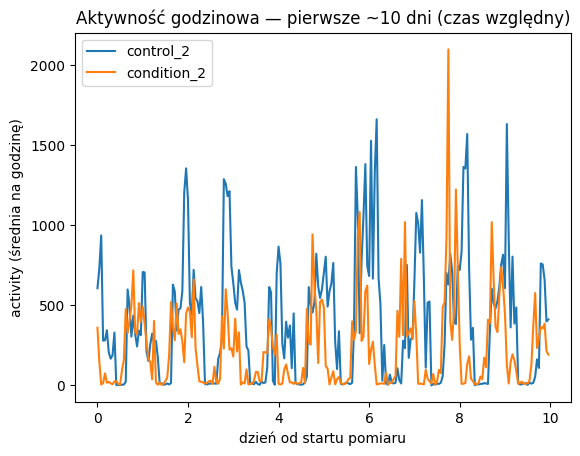

In [23]:
# Porównanie pierwszych ~10 dni, ale względem startu pomiaru (dzień 0)
n = 24 * 10

c = s_c.iloc[:n].to_numpy()
d = s_d.iloc[:n].to_numpy()

x_days = np.arange(n) / 24  # oś X w dniach

plt.figure()
plt.plot(x_days, c, label=best_control)
plt.plot(x_days, d, label=best_condition)
plt.title("Aktywność godzinowa — pierwsze ~10 dni (czas względny)")
plt.xlabel("dzień od startu pomiaru")
plt.ylabel("activity (średnia na godzinę)")
plt.legend()
plt.show()

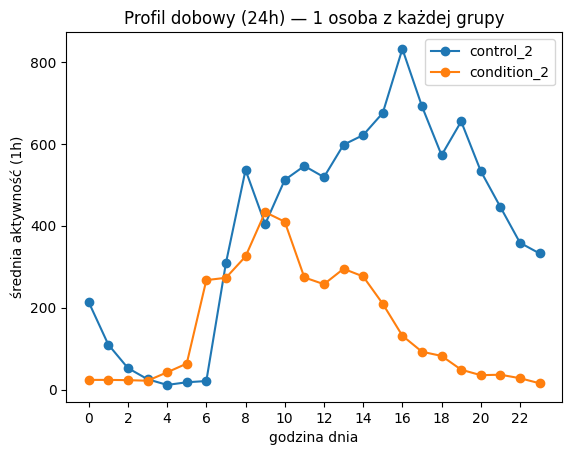

In [24]:
def circadian_profile(pid: str) -> pd.Series:
    s = load_participant_series(pid, "1h")
    df = s.to_frame("activity")
    df["hour"] = df.index.hour
    return df.groupby("hour")["activity"].mean()

prof_c = circadian_profile(best_control)
prof_d = circadian_profile(best_condition)

plt.figure()
plt.plot(prof_c.index, prof_c.values, marker="o", label=best_control)
plt.plot(prof_d.index, prof_d.values, marker="o", label=best_condition)
plt.title("Profil dobowy (24h) — 1 osoba z każdej grupy")
plt.xlabel("godzina dnia")
plt.ylabel("średnia aktywność (1h)")
plt.xticks(range(0,24,2))
plt.legend()
plt.show()

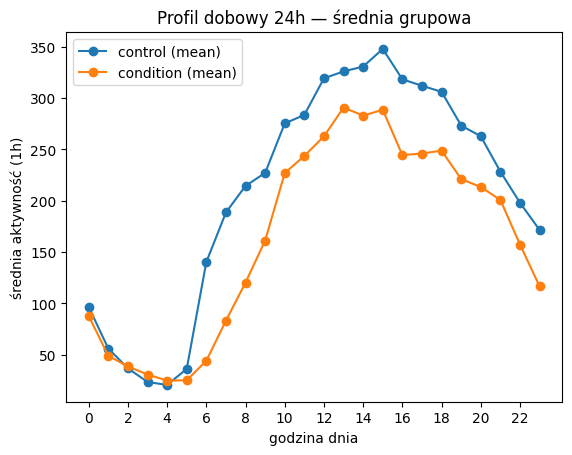

In [25]:
def circadian_profile_for_group(pids: list[str]) -> pd.DataFrame:
    rows = []
    for pid in pids:
        s = load_participant_series(pid, "1h")
        tmp = s.to_frame("activity")
        tmp["hour"] = tmp.index.hour
        prof = tmp.groupby("hour")["activity"].mean()
        rows.append(pd.DataFrame({"pid": pid, "hour": prof.index, "activity": prof.values}))
    return pd.concat(rows, ignore_index=True)

control_prof = circadian_profile_for_group(control_ids)
cond_prof = circadian_profile_for_group(condition_ids)

control_g = control_prof.groupby("hour")["activity"].mean()
cond_g = cond_prof.groupby("hour")["activity"].mean()

plt.figure()
plt.plot(control_g.index, control_g.values, marker="o", label="control (mean)")
plt.plot(cond_g.index, cond_g.values, marker="o", label="condition (mean)")
plt.title("Profil dobowy 24h — średnia grupowa")
plt.xlabel("godzina dnia")
plt.ylabel("średnia aktywność (1h)")
plt.xticks(range(0,24,2))
plt.legend()
plt.show()


## 3. Metryki rytmu dobowego

Definicje (dla profilu 24h):
- `day_mean`: średnia aktywność w godzinach 9–21
- `night_mean`: średnia aktywność w godzinach 0–6
- `amp = day_mean - night_mean`
- `day_night_ratio = (day_mean+1)/(night_mean+1)`
- `rel_amp = (max-min)/(max+min)`


In [26]:
DAY_HOURS = list(range(9, 22))
NIGHT_HOURS = list(range(0, 7))

def circadian_metrics(profile_df: pd.DataFrame) -> pd.DataFrame:
    metrics = []
    for pid, sub in profile_df.groupby("pid"):
        day = sub[sub["hour"].isin(DAY_HOURS)]["activity"].mean()
        night = sub[sub["hour"].isin(NIGHT_HOURS)]["activity"].mean()
        amp = day - night
        ratio = (day + 1) / (night + 1)
        mx = sub["activity"].max()
        mn = sub["activity"].min()
        rel_amp = (mx - mn) / (mx + mn + 1e-9)
        metrics.append((pid, day, night, amp, ratio, rel_amp))
    return pd.DataFrame(metrics, columns=["pid","day_mean","night_mean","amp","day_night_ratio","rel_amp"])

m_control = circadian_metrics(control_prof)
m_cond = circadian_metrics(cond_prof)

metrics_df = pd.concat([
    m_control.assign(group="control"),
    m_cond.assign(group="condition")
], ignore_index=True)

metrics_df.head()

,pid,day_mean,night_mean,amp,day_night_ratio,rel_amp,group
0,control_1,144.916521,30.016733,114.899789,4.704445,0.881736,control
1,control_10,394.826012,77.877143,316.948869,5.018260,0.975389,control
2,control_11,224.127864,49.147479,174.980385,4.489316,0.976537,control
3,control_12,141.144869,21.117659,120.027210,6.426759,0.950850,control
4,control_13,249.569955,39.715397,209.854558,6.154182,0.932873,control


**Podsumowanie metryk w grupie**

In [27]:
metrics_df.groupby("group")[["day_mean","night_mean","amp","day_night_ratio","rel_amp"]].agg(["mean","std","median"])

day_mean                         night_mean                               amp                          \
                 mean         std      median       mean        std     median        mean         std      median   
group                                                                                                                
condition  240.876444  106.738067  243.360533  42.946533  25.122794  41.615397  197.929912  104.881516  215.678956   
control    293.113615  119.506391  276.344426  58.624951  32.178820  49.851566  234.488664  106.809437  225.300437   

          day_night_ratio                       rel_amp                      
                     mean       std    median      mean       std    median  
group                                                                        
condition        7.950176  6.030001  6.042395  0.920230  0.070632  0.935684  
control          5.598405  2.011476  5.595748  0.927737  0.069765  0.939050

### 4A. Standaryzacja okna: metryki na pierwszych 7 dniach (168h)

Cel: porównać grupy na wspólnym fragmencie czasu, mimo że osoby mają różną liczbę dni pomiaru.


In [28]:
H = 24 * 7  # 168h

def circadian_profile_first_k_days(pid: str, k_hours: int = H, freq: str = "1h") -> pd.DataFrame | None:
    s = load_participant_series(pid, freq)
    if len(s) < k_hours:
        return None
    s = s.iloc[:k_hours]
    df = s.to_frame("activity")
    df["pid"] = pid
    df["hour"] = df.index.hour
    # profil: średnia aktywność w danej godzinie (0..23) z pierwszych k godzin
    prof = df.groupby(["pid","hour"], as_index=False)["activity"].mean()
    return prof

profiles_7d = []
used_7d = {"control": [], "condition": []}

for pid in control_ids + condition_ids:
    prof = circadian_profile_first_k_days(pid, H, "1h")
    if prof is not None:
        profiles_7d.append(prof)
        used_7d["control" if pid.startswith("control") else "condition"].append(pid)

prof_7d_df = pd.concat(profiles_7d, ignore_index=True)

metrics_7d = circadian_metrics(prof_7d_df)
metrics_7d["group"] = metrics_7d["pid"].apply(lambda x: "condition" if x.startswith("condition") else "control")

print("Uczestnicy z ≥7 dni:")
print("control  :", len(used_7d["control"]))
print("condition:", len(used_7d["condition"]))

metrics_7d.groupby("group")[["day_mean","night_mean","amp","day_night_ratio","rel_amp"]].agg(["mean","std","median"])


Uczestnicy z ≥7 dni:
control  : 32
condition: 23


day_mean                         night_mean                               amp                          \
                 mean         std      median       mean        std     median        mean         std      median   
group                                                                                                                
condition  257.975254  116.952130  256.820330  48.211786  30.655363  43.073129  209.763468  119.778788  208.405730   
control    390.582086  119.371843  367.250916  79.641741  45.802710  70.668027  310.940345  118.392491  305.318734   

          day_night_ratio                       rel_amp                      
                     mean       std    median      mean       std    median  
group                                                                        
condition        8.424129  7.228031  6.052527  0.937304  0.063334  0.959016  
control          6.252749  4.380530  5.267125  0.933981  0.066633  0.958578

**WNIOSKI**

W analizie wskaźników rytmu dobowego grupa **condition** wykazuje niższą aktywność dzienną i nocną niż grupa **control**. 

Równocześnie **amplituda dzień–noc (amp)** jest niższa w condition, co sugeruje mniej wyraźny (bardziej spłaszczony) rytm dobowy. 

Wskaźnik **day_night_ratio** w condition ma wyższy stosunek day/night, czyli proporcjonalnie dzień jest znacznie większy względem nocy niż w control.

Metryka **rel_amp** jest zbliżona w obu grupach, więc w tym zbiorze danych słabo różnicuje grupy.

In [29]:
# === Testy Welch + Cohen's d po standaryzacji (pierwsze 7 dni) ===

def cohens_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a[~np.isnan(a)]; b = b[~np.isnan(b)]
    n1, n2 = len(a), len(b)
    s1, s2 = np.var(a, ddof=1), np.var(b, ddof=1)
    sp = np.sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1+n2-2))
    return (np.mean(a) - np.mean(b)) / (sp + 1e-9)

rows = []
for col in ["day_mean","night_mean","amp","day_night_ratio","rel_amp"]:
    a = metrics_7d.loc[metrics_7d.group=="control", col]
    b = metrics_7d.loc[metrics_7d.group=="condition", col]
    t, p = stats.ttest_ind(a, b, equal_var=False, nan_policy="omit")
    d = cohens_d(a, b)
    rows.append((col, t, p, d, int(a.notna().sum()), int(b.notna().sum())))

test_results_7d = (pd.DataFrame(rows, columns=["metric","t_stat","p_value","cohens_d","n_control","n_condition"])
                   .sort_values("p_value"))
test_results_7d


,metric,t_stat,p_value,cohens_d,n_control,n_condition
0,day_mean,4.111987,0.000152,1.120241,32,23
2,amp,3.104980,0.003214,0.850441,32,23
1,night_mean,3.046749,0.003607,0.781571,32,23
3,day_night_ratio,-1.281467,0.208831,-0.378504,32,23
4,rel_amp,-0.187751,0.851848,-0.050892,32,23


### 4B. Test różnic w całym profilu 24h (pierwsze 7 dni)

- testy godzinowe (Welch) + korekta wielokrotnych porównań (FDR),
- bootstrap CI średniego profilu 24h (po osobach).


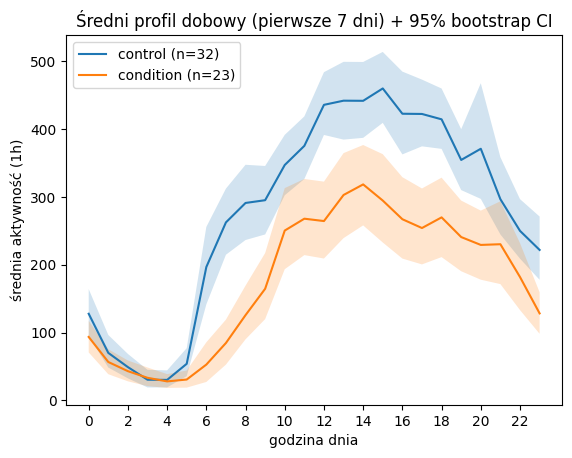

,hour,mean_control,mean_condition,t,p_value,p_adj_fdr_bh,reject_fdr_bh_0.05
7,7,262.379390,84.542650,5.736890,5.374417e-07,0.000013,True
8,8,291.029554,125.633540,4.697390,1.976523e-05,0.000237,True
12,12,435.710714,264.344928,4.477852,5.117744e-05,0.000409,True
6,6,196.556399,52.709213,4.293484,8.979054e-05,0.000431,True
17,17,422.262798,254.064286,4.301182,8.493329e-05,0.000431,True
15,15,459.874330,294.558385,3.708138,5.616450e-04,0.002247,True
18,18,414.350670,269.775673,3.664573,6.793087e-04,0.002329,True
9,9,295.093601,164.467081,3.571548,7.839738e-04,0.002352,True
16,16,422.592485,267.051242,3.514538,9.378301e-04,0.002501,True
23,23,221.758259,128.193375,3.177474,2.540752e-03,0.005646,True


In [30]:
from statsmodels.stats.multitest import multipletests

# macierz: pid x hour (0..23)
mat_7d = prof_7d_df.pivot_table(index="pid", columns="hour", values="activity").reindex(columns=range(24))

ctrl_pids_7d = [p for p in mat_7d.index if p.startswith("control")]
cond_pids_7d = [p for p in mat_7d.index if p.startswith("condition")]

A = mat_7d.loc[ctrl_pids_7d].to_numpy()
B = mat_7d.loc[cond_pids_7d].to_numpy()

def bootstrap_mean_ci(arr2d: np.ndarray, n_boot: int = 2000, alpha: float = 0.05, seed: int = 42):
    """Bootstrap CI po osobach. arr2d: [n_people, 24]"""
    rng = np.random.default_rng(seed)
    n = arr2d.shape[0]
    boots = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        boots.append(np.nanmean(arr2d[idx, :], axis=0))
    boots = np.vstack(boots)
    lo = np.quantile(boots, alpha/2, axis=0)
    hi = np.quantile(boots, 1-alpha/2, axis=0)
    mu = np.nanmean(arr2d, axis=0)
    return mu, lo, hi

muA, loA, hiA = bootstrap_mean_ci(A)
muB, loB, hiB = bootstrap_mean_ci(B)

plt.figure()
plt.plot(range(24), muA, label=f"control (n={len(ctrl_pids_7d)})")
plt.fill_between(range(24), loA, hiA, alpha=0.2)
plt.plot(range(24), muB, label=f"condition (n={len(cond_pids_7d)})")
plt.fill_between(range(24), loB, hiB, alpha=0.2)
plt.title("Średni profil dobowy (pierwsze 7 dni) + 95% bootstrap CI")
plt.xlabel("godzina dnia")
plt.ylabel("średnia aktywność (1h)")
plt.xticks(range(0,24,2))
plt.legend()
plt.show()

# Test różnic per godzina
rows = []
pvals = []
for h in range(24):
    a = mat_7d.loc[ctrl_pids_7d, h].dropna().to_numpy()
    b = mat_7d.loc[cond_pids_7d, h].dropna().to_numpy()
    if len(a) < 5 or len(b) < 5:
        p = np.nan
        t = np.nan
    else:
        t, p = stats.ttest_ind(a, b, equal_var=False)
    rows.append((h, np.nanmean(a), np.nanmean(b), t, p))
    pvals.append(p)

hour_tests = pd.DataFrame(rows, columns=["hour","mean_control","mean_condition","t","p_value"])

# korekta FDR (pomijamy NaN)
mask = hour_tests["p_value"].notna()
rej, p_adj, _, _ = multipletests(hour_tests.loc[mask, "p_value"], method="fdr_bh", alpha=0.05)
hour_tests.loc[mask, "p_adj_fdr_bh"] = p_adj
hour_tests.loc[mask, "reject_fdr_bh_0.05"] = rej

hour_tests.sort_values("p_adj_fdr_bh").head(10)


**Testy statystyczne:** Welch t-test + Cohen’s 

In [31]:
def cohens_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a[~np.isnan(a)]; b = b[~np.isnan(b)]
    n1, n2 = len(a), len(b)
    s1, s2 = np.var(a, ddof=1), np.var(b, ddof=1)
    sp = np.sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1+n2-2))
    return (np.mean(a) - np.mean(b)) / (sp + 1e-9)

rows = []
for col in ["day_mean","night_mean","amp","day_night_ratio","rel_amp"]:
    a = metrics_df.loc[metrics_df.group=="control", col]
    b = metrics_df.loc[metrics_df.group=="condition", col]
    t, p = stats.ttest_ind(a, b, equal_var=False, nan_policy="omit")
    d = cohens_d(a, b)
    rows.append((col, t, p, d))

test_results = pd.DataFrame(rows, columns=["metric","t_stat","p_value","cohens_d"]).sort_values("p_value")
test_results

,metric,t_stat,p_value,cohens_d
1,night_mean,2.027454,0.047698,0.532269
3,day_night_ratio,-1.799841,0.083709,-0.562828
0,day_mean,1.702292,0.094857,0.456700
2,amp,1.265339,0.211849,0.344850
4,rel_amp,0.390770,0.697726,0.107043


**WNIOSKI:**

Porównanie wskaźników rytmu dobowego między grupami wykonano testem Welcha. 

Aktywność nocna (night_mean) była istotnie wyższa w grupie kontrolnej (p=0.0477, d=0.53). 

Aktywność dzienna (day_mean) oraz wskaźnik day_night_ratio wykazały jedynie trend różnic (p≈0.09), natomiast amplituda (amp) i rel_amp nie były istotne.

/var/folders/fn/wcj0_ccx7gb_97ntt76x11sr0000gn/T/ipykernel_59345/1577046134.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a_day, b_day], labels=["control", "condition"], showfliers=True)


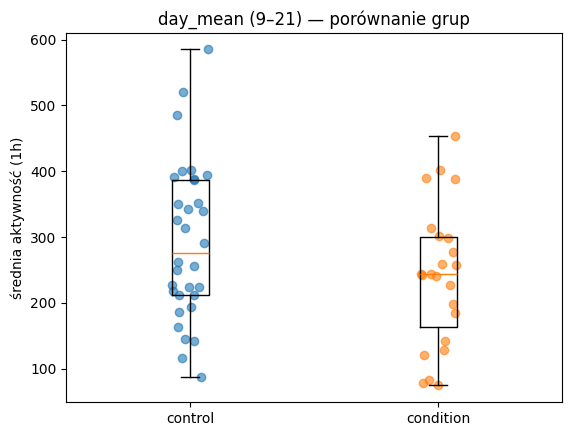

/var/folders/fn/wcj0_ccx7gb_97ntt76x11sr0000gn/T/ipykernel_59345/1577046134.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a_amp, b_amp], labels=["control", "condition"], showfliers=True)


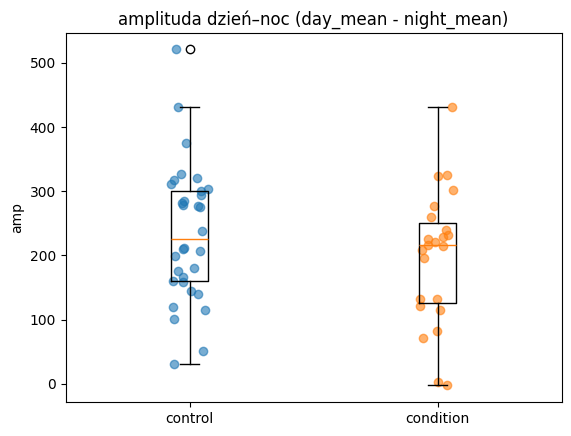

In [33]:
# Wykresy rozkładów 
np.random.seed(42)

# --- day_mean ---
a_day = metrics_df.loc[metrics_df.group=="control", "day_mean"].dropna()
b_day = metrics_df.loc[metrics_df.group=="condition", "day_mean"].dropna()

plt.figure()
plt.boxplot([a_day, b_day], labels=["control", "condition"], showfliers=True)
x1 = 1 + (np.random.rand(len(a_day)) - 0.5)*0.15
x2 = 2 + (np.random.rand(len(b_day)) - 0.5)*0.15
plt.scatter(x1, a_day, alpha=0.6)
plt.scatter(x2, b_day, alpha=0.6)
plt.title("day_mean (9–21) — porównanie grup")
plt.ylabel("średnia aktywność (1h)")
plt.show()

# --- amp ---
a_amp = metrics_df.loc[metrics_df.group=="control", "amp"].dropna()
b_amp = metrics_df.loc[metrics_df.group=="condition", "amp"].dropna()

plt.figure()
plt.boxplot([a_amp, b_amp], labels=["control", "condition"], showfliers=True)
x1 = 1 + (np.random.rand(len(a_amp)) - 0.5)*0.15
x2 = 2 + (np.random.rand(len(b_amp)) - 0.5)*0.15
plt.scatter(x1, a_amp, alpha=0.6)
plt.scatter(x2, b_amp, alpha=0.6)
plt.title("amplituda dzień–noc (day_mean - night_mean)")
plt.ylabel("amp")
plt.show()


Obie grupy mają bardzo podobny poziom amp, ta mają zbliżoną medianę.

In [ ]:
# MADRS (madrs1/madrs2) — korelacja z metrykami 

madrs = scores[["number","madrs1","madrs2"]].rename(columns={"number":"pid"})
merged = metrics_df.merge(madrs, on="pid", how="left").dropna(subset=["madrs1"])

print("n (z dostępnym madrs1) =", len(merged))

r, p = stats.pearsonr(merged["day_mean"], merged["madrs1"])
print("Pearson r(day_mean, madrs1) =", r, "| p =", p)


n (z dostępnym madrs1) = 23
Pearson r(day_mean, madrs1) = 0.10569496420819965 | p = 0.6312446510968541


Korelację liczysz **tylko na podzbiorze osób z dostępnym `madrs`**.

- Z wynniku r wynika bardzo słaba dodatnia korelacja między średnią aktywnością w dzień, a wynikiem skali depresji MADRS. 
- p = 0.631 oznacza, że nie ma podstaw, żeby uznać ten związek za istotny statystycznie.
- To nie wyklucza zależności nieliniowych ani tego, że inne cechy rytmu mogą lepiej wiązać się z MADRS.


## 5. Modele czasowe — prognoza 48h (jedna osoba)

- Cel: sprawdzić, czy proste modele bazowe (sezonowość 24h) wystarczają.
- W SARIMAX wybieramy wariant po **MAE na walidacji**, bo celem jest dokładność prognozy, a AIC jest kryterium dopasowania.


In [35]:
def train_test_split_series(s: pd.Series, test_h: int = 48):
    if len(s) <= test_h + 24:
        raise ValueError("Za krótka seria na sensowny train/test. Wybierz inną osobę.")
    return s.iloc[:-test_h], s.iloc[-test_h:]

# Bierzemy osobę z największą liczbą dni (stabilniejsza prognoza)
pid = best_condition

s = load_participant_series(pid, "1h")
train_raw, test_raw = train_test_split_series(s, test_h=48)

# Stabilizacja wariancji: log1p
y_train = np.log1p(train_raw)
y_test  = np.log1p(test_raw)

print("PID:", pid)
print("Długość całej serii (1h):", len(s))
print("Train:", y_train.index.min(), "->", y_train.index.max(), "| n=", len(y_train))
print("Test :", y_test.index.min(), "->", y_test.index.max(), "| n=", len(y_test))

PID: condition_2
Długość całej serii (1h): 649
Train: 2003-05-07 15:00:00 -> 2003-06-01 15:00:00 | n= 601
Test : 2003-06-01 16:00:00 -> 2003-06-03 15:00:00 | n= 48


In [37]:
def winsorize_series(s: pd.Series, lower_q=0.01, upper_q=0.99):
    lo = s.quantile(lower_q)
    hi = s.quantile(upper_q)
    return s.clip(lower=lo, upper=hi), lo, hi

y_train_w, lo, hi = winsorize_series(y_train, 0.01, 0.99)
lo, hi

(np.float64(1.8588987720656835), np.float64(7.025967852003766))

**Model 1: Seasonal Naive**

In [38]:
season = 24

last_day = y_train.iloc[-season:]
y_pred_naive = pd.Series(np.resize(last_day.values, len(y_test)), index=y_test.index)

mae_naive = mean_absolute_error(y_test, y_pred_naive)
mse_naive = mean_squared_error(y_test, y_pred_naive)
mae_naive, mse_naive

print("MAE:", mae_naive, "MSE:", mse_naive)

MAE: 0.40112353930920847 MSE: 0.9739724249438283


**Model 2: Exponential Smoothing (Holt-Winters)**

In [39]:
ets = ExponentialSmoothing(
    y_train,
    trend="add",
    seasonal="add",
    seasonal_periods=24
).fit(optimized=True, use_brute=True)

y_pred_ets = ets.forecast(len(y_test))

mae_ets = mean_absolute_error(y_test, y_pred_ets)
mse_ets = mean_squared_error(y_test, y_pred_ets)

# AIC bywa dostępne (zależy od wersji statsmodels)
ets_aic = getattr(ets, "aic", np.nan)

mae_ets, mse_ets, ets_aic

(1.2559350524149882, 2.2999680091112924, np.float64(-98.22939413820515))

**Model 3: SARIMAX**

In [41]:
# === SARIMAX mini-grid: wybór po MAE (cel: prognoza) ===

candidates = [
    ((1,0,1), (1,0,1,24), "c"),
    ((2,0,1), (1,0,1,24), "c"),
    ((1,0,2), (1,0,1,24), "c"),
    ((1,0,1), (2,0,1,24), "c"),
    ((1,0,1), (1,0,2,24), "c"),
    ((1,0,1), (1,0,1,24), "n"),
]

rows = []
sarimax_fits = {}

for order, seas, trend in candidates:
    try:
        m = sm.tsa.statespace.SARIMAX(
            y_train_w, 
            order=order,
            seasonal_order=seas,
            trend=trend,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False, maxiter=50)

        pred = m.forecast(len(y_test))

        mae = mean_absolute_error(y_test, pred)
        mse = mean_squared_error(y_test, pred)

        rows.append((order, seas, trend, m.aic, mae, mse))
        sarimax_fits[(order, seas, trend)] = (m, pred)

    except Exception as e:
        rows.append((order, seas, trend, np.nan, np.nan, np.nan))

sarimax_grid = pd.DataFrame(
    rows,
    columns=["order","seasonal_order","trend","AIC","MAE(log1p)","MSE(log1p)"]
).sort_values("MAE(log1p)")

sarimax_grid


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,order,seasonal_order,trend,AIC,MAE(log1p),MSE(log1p)
1,"(2, 0, 1)","(1, 0, 1, 24)",c,1490.397802,0.595262,0.950387
2,"(1, 0, 2)","(1, 0, 1, 24)",c,1492.708856,0.656733,0.806301
5,"(1, 0, 1)","(1, 0, 1, 24)",n,1512.542373,0.705354,0.850040
3,"(1, 0, 1)","(2, 0, 1, 24)",c,1447.986211,0.725492,0.868407
4,"(1, 0, 1)","(1, 0, 2, 24)",c,1444.404063,0.738917,0.866172
0,"(1, 0, 1)","(1, 0, 1, 24)",c,1504.806353,0.753621,0.907239


In [42]:
best_row = sarimax_grid.dropna(subset=["MAE(log1p)"]).iloc[0]
best_key = (best_row["order"], best_row["seasonal_order"], best_row["trend"])

best_sarimax_model, y_pred_sarimax = sarimax_fits[best_key]

print("BEST SARIMAX by MAE(log1p):")
print("order =", best_key[0], "| seasonal =", best_key[1], "| trend =", best_key[2])
print("MAE  =", mean_absolute_error(y_test, y_pred_sarimax))
print("MSE  =", mean_squared_error(y_test, y_pred_sarimax))
print("AIC  =", best_sarimax_model.aic)


BEST SARIMAX by MAE(log1p):
order = (2, 0, 1) | seasonal = (1, 0, 1, 24) | trend = c
MAE  = 0.5952617595953794
MSE  = 0.9503870080780912
AIC  = 1490.3978016541116


W grid-search SARIMAX kryterium dopasowania (AIC) nie pokrywa się z kryterium jakości prognozy (MAE/MSE). Modele o najniższym AIC osiągały gorsze błędy prognozy na teście. Najlepszą prognozę wg MAE uzyskał model (2,0,1)×(1,0,1,24) z trendem c, natomiast najniższy MSE miał wariant (1,0,2)×(1,0,1,24), co sugeruje kompromis między średnim błędem a odpornością na duże odchylenia. 

**Porównanie modeli**

In [43]:
compare = pd.DataFrame([
    ("seasonal_naive", mae_naive, mse_naive, np.nan),
    ("ETS_HoltWinters", mae_ets, mse_ets, ets_aic),
    (f"SARIMAX_best_MAE {best_key}", 
     mean_absolute_error(y_test, y_pred_sarimax),
     mean_squared_error(y_test, y_pred_sarimax),
     best_sarimax_model.aic)
], columns=["model", "MAE (log1p)", "MSE (log1p)", "AIC"]).sort_values("MAE (log1p)")

compare


,model,MAE (log1p),MSE (log1p),AIC
0,seasonal_naive,0.401124,0.973972,NaN
2,"SARIMAX_best_MAE ((2, 0, 1), (1, 0, 1, 24), 'c')",0.595262,0.950387,1490.397802
1,ETS_HoltWinters,1.255935,2.299968,-98.229394


**Wykres prognozy**

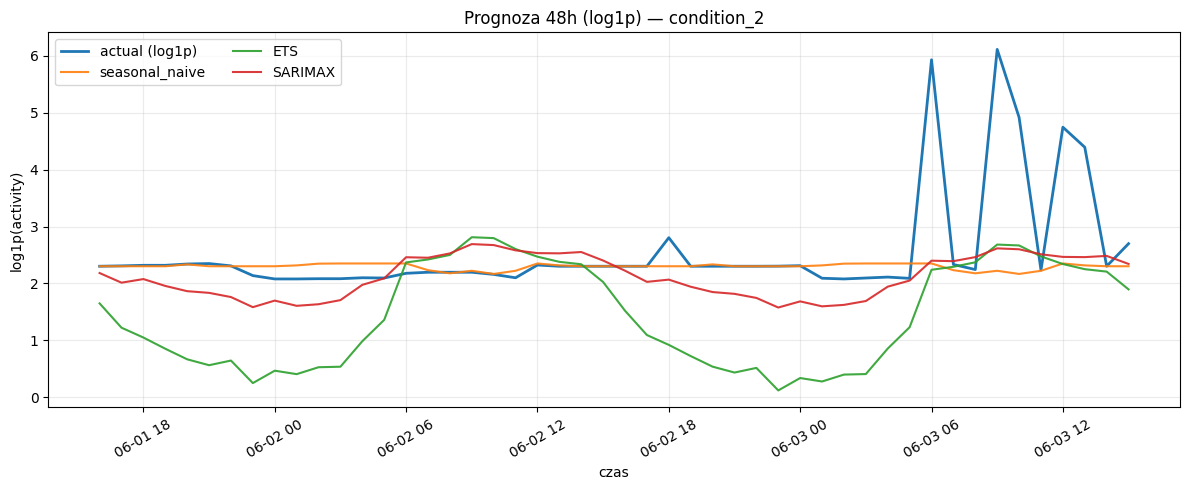

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# tu rysujemy BEZ expm1, czyli na log1p skali
plt.plot(y_test.index, y_test.values, label="actual (log1p)", linewidth=2)
plt.plot(y_test.index, y_pred_naive.values, label="seasonal_naive", alpha=0.9)
plt.plot(y_test.index, y_pred_ets.values, label="ETS", alpha=0.9)
plt.plot(y_test.index, y_pred_sarimax.values, label="SARIMAX", alpha=0.9)

plt.title(f"Prognoza 48h (log1p) — {pid}")
plt.xlabel("czas")
plt.ylabel("log1p(activity)")
plt.grid(True, alpha=0.25)
plt.legend(ncol=2)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## 6. Anomalie na resztach modelu

Wykrywamy punkty odstające na resztach najlepszego modelu (domyślnie `seasonal_naive`). Stosujemy regułę **3σ** (ale pozniej bardziej sie sprawdzila 2.5σ ) opartą o odchylenie standardowe reszt z treningu.


In [ ]:
# Najlepszy model seasonal_naive
y_pred_best = y_pred_naive

# Reszty na teście
resid_test = (y_test - y_pred_best)

# Reszty na treningu dla baseline: porównanie do wartości sprzed 24h
train_resid = (y_train - y_train.shift(24)).dropna()

threshold = 3 * train_resid.std()
threshold_25 = 2.5 * train_resid.std()
threshold_2  = 2.0 * train_resid.std()

print("próg 3", threshold, "próg 2.5σ", threshold_25, "próg 2σ", threshold_2)


próg 3 4.030452948128296 próg 2.5σ 3.3587107901069135 próg 2σ 2.686968632085531


In [55]:
anoms = resid_test[np.abs(resid_test) > threshold_25].to_frame("resid_log1p")

anoms["activity_actual"] = np.expm1(y_test.loc[anoms.index])
anoms["activity_pred"]   = np.expm1(y_pred_best.loc[anoms.index])
anoms["abs_error"] = np.abs(anoms["activity_actual"] - anoms["activity_pred"])

anoms.sort_values("abs_error", ascending=False).head(15)


,resid_log1p,activity_actual,activity_pred,abs_error
timestamp,,,,
2003-06-03 09:00:00,3.890161,450.683333,8.233333,442.45
2003-06-03 06:00:00,3.579277,375.400000,9.500000,365.90


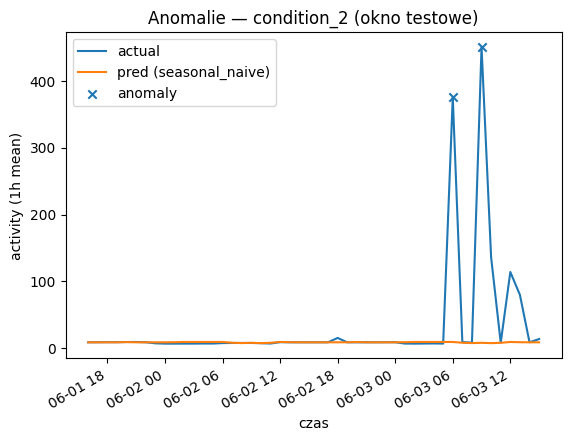

In [56]:
import matplotlib.dates as mdates

actual = np.expm1(y_test)
pred   = np.expm1(y_pred_best)

plt.figure()
plt.plot(actual.index, actual.values, label="actual")
plt.plot(pred.index, pred.values, label="pred (seasonal_naive)")

if len(anoms) > 0:
    plt.scatter(anoms.index, anoms["activity_actual"].values, marker="x", label="anomaly")

plt.title(f"Anomalie — {pid} (okno testowe)")
plt.xlabel("czas")
plt.ylabel("activity (1h mean)")

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H'))
plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

In [58]:
night_p = float(test_results.loc[test_results.metric=="night_mean", "p_value"].iloc[0])
night_d = float(test_results.loc[test_results.metric=="night_mean", "cohens_d"].iloc[0])

day_p = float(test_results.loc[test_results.metric=="day_mean", "p_value"].iloc[0])
day_d = float(test_results.loc[test_results.metric=="day_mean", "cohens_d"].iloc[0])

best_mae = float(compare.iloc[0]["MAE (log1p)"])
best_mse = float(compare.iloc[0]["MSE (log1p)"])
best_model = compare.iloc[0]["model"]

n_anoms = len(anoms)

print("WNIOSKI:\n")
print(f"- Profil dobowy: grupa condition wykazuje niższą aktywność dzienną (trend zgodny z wykresami).")
print(f"- Wskaźniki: night_mean różni grupy istotnie (p={night_p:.4f}, d={night_d:.2f}); day_mean ma trend (p={day_p:.4f}, d={day_d:.2f}).")
print(f"- Prognoza 48h: najlepszy model to {best_model} (MAE={best_mae:.3f}, MSE={best_mse:.3f} w log1p), co sugeruje silną sezonowość 24h.")
print(f"- Anomalie: wykryto {n_anoms} punkt(y/ów) odstających w oknie testowym (2.5σ na resztach), odpowiadających nagłym pikom aktywności.")


WNIOSKI:

- Profil dobowy: grupa condition wykazuje niższą aktywność dzienną (trend zgodny z wykresami).
- Wskaźniki: night_mean różni grupy istotnie (p=0.0477, d=0.53); day_mean ma trend (p=0.0949, d=0.46).
- Prognoza 48h: najlepszy model to seasonal_naive (MAE=0.401, MSE=0.974 w log1p), co sugeruje silną sezonowość 24h.
- Anomalie: wykryto 2 punkt(y/ów) odstających w oknie testowym (2.5σ na resztach), odpowiadających nagłym pikom aktywności.


In [59]:
# In-sample (train) – żeby pokazać sezonowość bez pików z testu
fit_naive = y_train.shift(24)                  # baseline dopasowanie
fit_ets   = ets.fittedvalues                   # ETS dopasowanie
fit_sar   = best_sarimax_model.fittedvalues    # SARIMAX dopasowanie

# wyrównanie indeksów (baseline ma NaN na początku)
df_fit = pd.DataFrame({
    "actual": y_train,
    "naive": fit_naive,
    "ETS": fit_ets,
    "SARIMAX": fit_sar
}).dropna()

df_fit.head()


,actual,naive,ETS,SARIMAX
timestamp,,,,
2003-05-08 15:00:00,6.201759,5.888555,5.671894,11.370506
2003-05-08 16:00:00,5.960318,4.996536,5.477156,2.432938
2003-05-08 17:00:00,5.588496,1.938742,5.332692,3.403559
2003-05-08 18:00:00,5.111184,2.732201,5.309348,6.607800
2003-05-08 19:00:00,5.002267,4.340988,4.996750,6.941373


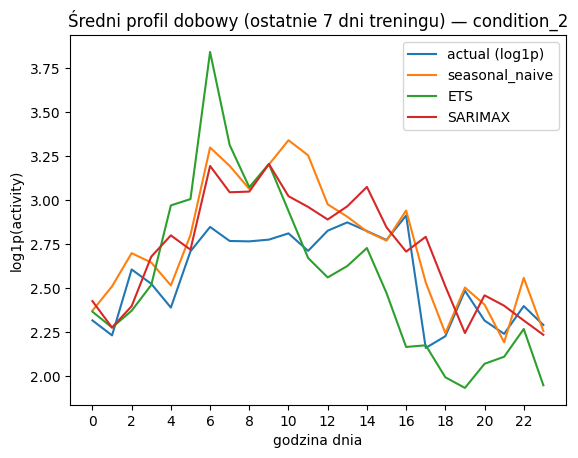

In [41]:
# bierzemy ostatnie 7 dni i układamy je dzień po dniu (0..23)
sub7 = df_fit.iloc[-24*7:]
sub7 = sub7.copy()
sub7["hour"] = sub7.index.hour
sub7["date"] = sub7.index.date

# średnia z dni dla actual i modeli
mean_by_hour = sub7.groupby("hour")[["actual","naive","ETS","SARIMAX"]].mean()

plt.figure()
plt.plot(mean_by_hour.index, mean_by_hour["actual"], label="actual (log1p)")
plt.plot(mean_by_hour.index, mean_by_hour["naive"],  label="seasonal_naive")
plt.plot(mean_by_hour.index, mean_by_hour["ETS"],    label="ETS")
plt.plot(mean_by_hour.index, mean_by_hour["SARIMAX"],label="SARIMAX")

plt.title(f"Średni profil dobowy (ostatnie 7 dni treningu) — {pid}")
plt.xlabel("godzina dnia")
plt.ylabel("log1p(activity)")
plt.xticks(range(0,24,2))
plt.legend()
plt.show()

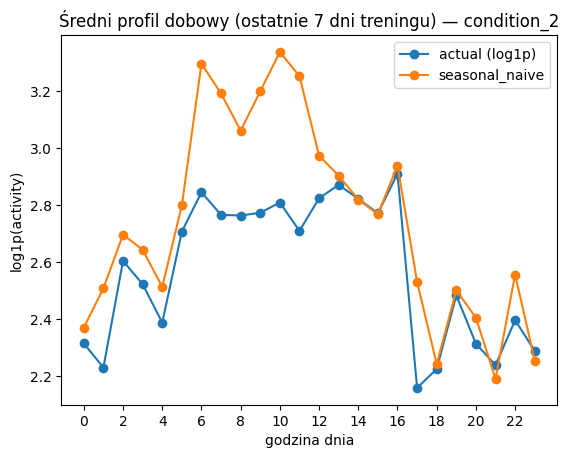

In [42]:
# 'Czyste' 7 dni = ostatnie 7 dni z df_fit (bez braków), porównanie actual vs seasonal_naive
df7_clean = sub7[["actual","naive"]].rename(columns={"naive":"pred"}).copy()

df7_clean["hour"] = df7_clean.index.hour
mean_hour = df7_clean.groupby("hour")[["actual","pred"]].mean()

plt.figure()
plt.plot(mean_hour.index, mean_hour["actual"], marker="o", label="actual (log1p)")
plt.plot(mean_hour.index, mean_hour["pred"],   marker="o", label="seasonal_naive")
plt.title(f"Średni profil dobowy (ostatnie 7 dni treningu) — {pid}")
plt.xlabel("godzina dnia")
plt.ylabel("log1p(activity)")
plt.xticks(range(0,24,2))
plt.legend()
plt.show()


## 6.2 Porównanie średniej aktywności w pierwszych 7 dniach (czas względny)

Uśredniamy serię godzinową (0..167) po osobach z ≥7 dniami, osobno dla grup.


In [60]:
def group_mean_first_7days(pids: list[str], freq="1h") -> tuple[pd.Series, int]:
    H = 24 * 7
    mat = []
    used = 0
    for pid in pids:
        s = load_participant_series(pid, freq)
        if len(s) >= H:
            mat.append(s.iloc[:H].to_numpy())
            used += 1
    mat = np.vstack(mat)  # shape: [n_people, 168]
    mean = np.nanmean(mat, axis=0)
    idx = pd.RangeIndex(start=0, stop=H, step=1, name="hour_from_start")
    return pd.Series(mean, index=idx), used

mean_control_7d, n_control_7d = group_mean_first_7days(control_ids)
mean_cond_7d, n_cond_7d    = group_mean_first_7days(condition_ids)

print("n used (>=7 dni): control =", n_control_7d, "| condition =", n_cond_7d)


n used (>=7 dni): control = 32 | condition = 23


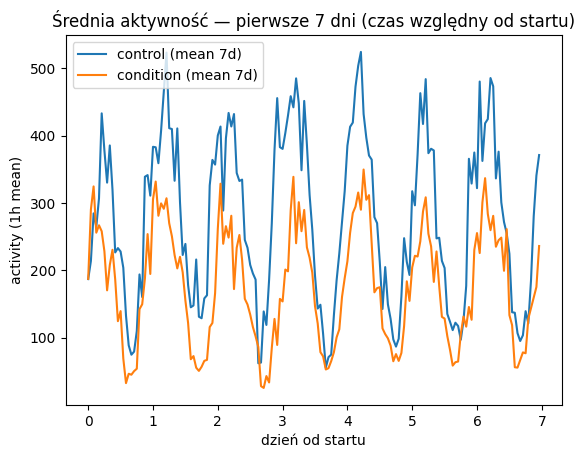

In [61]:
x_days = mean_control_7d.index / 24

plt.figure()
plt.plot(x_days, mean_control_7d.values, label="control (mean 7d)")
plt.plot(x_days, mean_cond_7d.values, label="condition (mean 7d)")
plt.title("Średnia aktywność — pierwsze 7 dni (czas względny od startu)")
plt.xlabel("dzień od startu")
plt.ylabel("activity (1h mean)")
plt.legend()
plt.show()


## 7. Benchmark modeli — walidacja na wielu osobach

Weryfikujemy, czy wnioski z jednej osoby są stabilne: porównujemy błędy modeli na kilku osobach w każdej grupie.


In [62]:
# wybierz kilka najdłuższych serii w każdej grupie (wg 'days' z scores.csv)
TOP_N = 3
top_control = scores[scores.group=="control"].sort_values("days", ascending=False)["number"].head(TOP_N).tolist()
top_condition = scores[scores.group=="condition"].sort_values("days", ascending=False)["number"].head(TOP_N).tolist()

pids_eval = top_control + top_condition
pids_eval

def eval_models_for_pid(pid: str, test_h: int = 48, season: int = 24):
    s = load_participant_series(pid, "1h")
    if len(s) <= test_h + season:
        return None

    y_train, y_test = train_test_split_series(np.log1p(s), test_h=test_h)

    # 1) seasonal naive
    last_day = y_train.iloc[-season:]
    y_pred_naive = pd.Series(np.resize(last_day.values, len(y_test)), index=y_test.index)
    mae_naive = mean_absolute_error(y_test, y_pred_naive)
    mse_naive = mean_squared_error(y_test, y_pred_naive)

    # 2) ETS
    try:
        ets = ExponentialSmoothing(
            y_train,
            trend="add",
            seasonal="add",
            seasonal_periods=season
        ).fit(optimized=True, use_brute=False)
        y_pred_ets = ets.forecast(len(y_test))
        mae_ets = mean_absolute_error(y_test, y_pred_ets)
        mse_ets = mean_squared_error(y_test, y_pred_ets)
    except Exception:
        mae_ets = np.nan
        mse_ets = np.nan

    # 3) SARIMAX
    try:
        m = sm.tsa.statespace.SARIMAX(
            y_train,
            order=(1,0,1),
            seasonal_order=(1,0,1,season),
            trend="c",
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False, maxiter=30)
        y_pred_sar = m.forecast(len(y_test))
        mae_sar = mean_absolute_error(y_test, y_pred_sar)
        mse_sar = mean_squared_error(y_test, y_pred_sar)
        aic_sar = m.aic
    except Exception:
        mae_sar = np.nan
        mse_sar = np.nan
        aic_sar = np.nan

    group = "condition" if pid.startswith("condition") else "control"
    return {
        "pid": pid,
        "group": group,
        "n_hours": len(s),
        "MAE_naive": mae_naive,
        "MSE_naive": mse_naive,
        "MAE_ETS": mae_ets,
        "MSE_ETS": mse_ets,
        "MAE_SARIMAX": mae_sar,
        "MSE_SARIMAX": mse_sar,
        "AIC_SARIMAX": aic_sar
    }

rows = []
for pid in pids_eval:
    out = eval_models_for_pid(pid)
    if out is not None:
        rows.append(out)

bench = pd.DataFrame(rows).sort_values(["group","MAE_naive"])
bench


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,pid,group,n_hours,MAE_naive,MSE_naive,MAE_ETS,MSE_ETS,MAE_SARIMAX,MSE_SARIMAX,AIC_SARIMAX
3,condition_2,condition,649,0.401124,0.973972,1.255873,2.299645,0.722342,0.858652,1517.179158
5,condition_23,condition,525,0.434941,1.003322,1.325119,2.577718,2.005988,4.494341,1407.900958
4,condition_16,condition,698,1.866305,6.658281,1.581853,3.783639,1.063772,2.196470,1606.679270
2,control_32,control,862,0.148323,0.219678,0.588642,0.738951,0.288256,0.273514,2014.084090
1,control_28,control,409,0.561610,0.533824,0.440316,0.327733,0.458811,0.355898,853.379504
0,control_2,control,525,2.960536,14.425911,2.924412,13.474534,2.935548,13.155807,1336.419224


### Podsumowanie benchmarku

Zobacz, czy „seasonal naive” nadal wygrywa jako bardzo mocny baseline (często tak jest przy silnej sezonowości 24h).


In [63]:
bench.groupby("group")[["MAE_naive","MAE_ETS","MAE_SARIMAX","MSE_naive","MSE_ETS","MSE_SARIMAX"]].agg(["mean","median","std"])


MAE_naive                       MAE_ETS                     MAE_SARIMAX                     MSE_naive  \
               mean    median       std      mean    median       std        mean    median       std      mean   
group                                                                                                             
condition   0.90079  0.434941  0.836332  1.387615  1.325119  0.171741    1.264034  1.063772  0.664842  2.878525   
control     1.22349  0.561610  1.518453  1.317790  0.588642  1.393350    1.227539  0.458811  1.481636  5.059805   

                                MSE_ETS                     MSE_SARIMAX                      
             median       std      mean    median       std        mean    median       std  
group                                                                                        
condition  1.003322  3.273398  2.887001  2.577718  0.788861    2.516488  2.196470  1.838849  
control    0.533824  8.112807  4.847073  0.738951  7.474429    4.595073  0.355898  7.413928

In [64]:
print("bench columns:", list(bench.columns))
print("bench head:")
display(bench.head())

bench columns: ['pid', 'group', 'n_hours', 'MAE_naive', 'MSE_naive', 'MAE_ETS', 'MSE_ETS', 'MAE_SARIMAX', 'MSE_SARIMAX', 'AIC_SARIMAX']
bench head:


,pid,group,n_hours,MAE_naive,MSE_naive,MAE_ETS,MSE_ETS,MAE_SARIMAX,MSE_SARIMAX,AIC_SARIMAX
3,condition_2,condition,649,0.401124,0.973972,1.255873,2.299645,0.722342,0.858652,1517.179158
5,condition_23,condition,525,0.434941,1.003322,1.325119,2.577718,2.005988,4.494341,1407.900958
4,condition_16,condition,698,1.866305,6.658281,1.581853,3.783639,1.063772,2.196470,1606.679270
2,control_32,control,862,0.148323,0.219678,0.588642,0.738951,0.288256,0.273514,2014.084090
1,control_28,control,409,0.561610,0.533824,0.440316,0.327733,0.458811,0.355898,853.379504


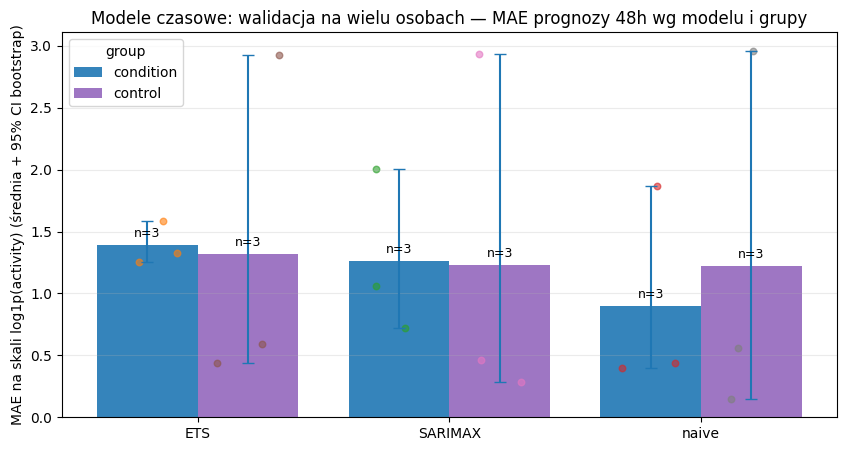

In [65]:
np.random.seed(42)

required = {"group", "pid"}
if not required.issubset(set(bench.columns)):
    raise ValueError(f"Brakuje kolumn {required} w bench. Mam: {list(bench.columns)}")

mae_cols = [c for c in bench.columns if c.startswith("MAE_")]
if not mae_cols:
    raise ValueError(f"Nie ma kolumn MAE_* w bench. Mam: {list(bench.columns)}")

bench_long = bench[["pid", "group"] + mae_cols].melt(
    id_vars=["pid", "group"],
    var_name="model",
    value_name="mae"
)
bench_long["model"] = bench_long["model"].str.replace("MAE_", "", regex=False)

# Bootstrap 95% CI po osobach dla średniej MAE
def bootstrap_ci_mean(values, n_boot=5000, ci=0.95, seed=123):
    """
    values: 1D array (MAE per person)
    returns: (mean, lo, hi)
    """
    values = np.asarray(values, dtype=float)
    values = values[~np.isnan(values)]
    if len(values) == 0:
        return np.nan, np.nan, np.nan
    rng = np.random.default_rng(seed)
    boots = rng.choice(values, size=(n_boot, len(values)), replace=True).mean(axis=1)
    lo = np.quantile(boots, (1-ci)/2)
    hi = np.quantile(boots, 1-(1-ci)/2)
    return float(values.mean()), float(lo), float(hi)

rows = []
for (g, m), sub in bench_long.groupby(["group", "model"]):
    vals = sub["mae"].dropna().values
    mean_, lo, hi = bootstrap_ci_mean(vals, n_boot=5000, ci=0.95, seed=123)
    rows.append({
        "group": g,
        "model": m,
        "n": len(vals),
        "mean": mean_,
        "ci_lo": lo,
        "ci_hi": hi
    })

summary = pd.DataFrame(rows)

# Ustal stabilną kolejność modeli (ETS, SARIMAX, naive)
order = ["ETS", "SARIMAX", "naive"]
models = [m for m in order if m in summary["model"].unique()] + \
         [m for m in summary["model"].unique() if m not in order]

groups = list(summary["group"].unique())

# Rysunek: słupki (mean) + errorbar (bootstrap CI) + kropki per osoba + n nad słupkiem
x = np.arange(len(models))
width = 0.8 / max(len(groups), 1)

fig, ax = plt.subplots(figsize=(10, 5))

for i, g in enumerate(groups):
    sub = summary[summary["group"] == g].set_index("model").reindex(models)

    offset = (i - (len(groups) - 1) / 2) * width
    xpos = x + offset

    means = sub["mean"].values
    lo = sub["ci_lo"].values
    hi = sub["ci_hi"].values
    yerr = np.vstack([means - lo, hi - means])  # asymetryczne CI

    ax.bar(xpos, means, width=width, label=str(g), alpha=0.9)
    ax.errorbar(xpos, means, yerr=yerr, fmt="none", capsize=4)

    # kropki dla każdej osoby
    for j, m in enumerate(models):
        vals = bench_long[(bench_long["group"] == g) & (bench_long["model"] == m)]["mae"].dropna().values
        if len(vals) == 0:
            continue
        jitter = (np.random.rand(len(vals)) - 0.5) * width * 0.65
        ax.scatter(np.full(len(vals), xpos[j]) + jitter, vals, s=22, alpha=0.6)

        n = len(vals)
        ax.text(xpos[j], means[j] + (0.03 * np.nanmax(means)), f"n={n}", ha="center", va="bottom", fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel("MAE na skali log1p(activity) (średnia + 95% CI bootstrap)")
ax.set_title("Modele czasowe: walidacja na wielu osobach — MAE prognozy 48h wg modelu i grupy")
ax.grid(True, axis="y", alpha=0.25)
ax.legend(title="group")
plt.show()


## 8. Wnioski

## Wnioski względem hipotez

### H1: *condition* ma niższą aktywność dzienną
- Hipoteza jest **mocno wsparta**: profil dobowy (24h) pokazuje istotne różnice między grupami w wielu godzinach dnia po korekcie FDR.
- W metrykach opisowych widać spójny kierunek: **`day_mean` jest niższe** w grupie *condition*.
- Testy na metrykach liczonych z pełnego okresu obserwacji dają tylko **trend**, co może wynikać z braku standaryzacji okna (różne długości rejestracji obniżają porównywalność i „rozmywają” efekt).

### H2: *condition* ma spłaszczony rytm dobowy
- Opisowo amplituda (`amp = day_mean - night_mean`) jest **niższa** w *condition*, co sugeruje spłaszczenie rytmu.
- W testach na metrykach liczonych z pełnych profili **brak istotności**, więc nie da się potwierdzić hipotezy wyłącznie jedną metryką amplitudy.
- Analiza profilu godzinowego wskazuje, że różnice są **rozłożone na wiele godzin** — to wspiera tezę o realnie innym „kształcie” rytmu dobowego w *condition*, nawet jeśli sama `amp` nie wychodzi istotna.

### H3: ETS będzie lepszy niż baseline w prognozie 48h
- Hipoteza **nie potwierdziła się**: ETS jest gorszy niż prosty baseline sezonowy.
- Najlepszy wynik daje **seasonal naive (sezon 24h)**, co sugeruje dominującą rolę **sezonowości dobowej** w krótkoterminowej prognozie.

### H4: reszty modelu pozwolą wykryć anomalie
- Hipoteza jest **częściowo potwierdzona**: na resztach modelu wykrywalne są skrajne odchylenia (np. pojedyncze duże piki).
- Wnioski wymagają doprecyzowania, bo detekcja zależy od progu (np. 3σ vs 2.5σ) — należy ujednolicić próg i jasno opisać ograniczenia metody.

## Wnioski względem obliczeń

### Rytm dobowy i różnice grup (control vs condition)
- Dane po agregacji do 1h mają wyraźną **sezonowość dobową (24h)**.
- Porównanie grup jest najbardziej wiarygodne po standaryzacji do **pierwszych 7 dni (168h)** (to samo okno czasu dla każdej osoby).
- Testy godzinowe profilu 24h (Welch + FDR) sugerują, że **w wielu godzinach dnia aktywność w condition jest niższa** niż w control (różnice dotyczą kształtu profilu, nie tylko jednej liczby).

### Metryki (day_mean / night_mean / amp)
- Testy na metrykach liczonych z całego okresu mogą „rozmywać” efekt (różne długości rejestracji).

### Modele czasowe (prognoza 48h)
- Bardzo mocnym baseline jest **seasonal_naive (24h)** — sugeruje, że najlepszym predyktorem jest wartość sprzed **24 godzin**.
- ETS i SARIMAX w tej konfiguracji nie gwarantują poprawy nad baseline (wymagają strojenia i bywają wrażliwe na skoki).

### Anomalie
- Reguła **2.5σ** na resztach pozwala wyłapać skrajne piki aktywności w oknie testowym.

### Ograniczenia
- Braki w MADRS powodują, że korelacje są liczone na podzbiorze danych.
- Dla wniosków o modelach na populacji warto zwiększyć `TOP_N` w benchmarku lub przetestować wszystkie osoby.
